<a href="https://colab.research.google.com/github/PratikStar/PratikStar.github.io/blob/master/vae_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational AutoEncoder

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2020/05/03<br>
**Last modified:** 2020/05/03<br>
**Description:** Convolutional Variational AutoEncoder (VAE) trained on MNIST digits.

## Setup

In [ ]:
# Also check this: https://www.tensorflow.org/tutorials/generative/cvae 
# Another good: https://learnopencv.com/variational-autoencoder-in-tensorflow/ 
# Learning to calculate the number of params: https://towardsdatascience.com/how-to-calculate-the-number-of-parameters-in-keras-models-710683dae0ca#:~:text=Conv2D%20Layers&text=By%20applying%20this%20formula%20to,1%20is%20the%20input%20channel.

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils.vis_utils import plot_model


## Create a sampling layer

In [ ]:

class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        print('sampling')
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


## Build the encoder

In [ ]:
latent_dim = 2
# param_number = output_channel_number * (input_channel_number * kernel_height * kernel_width + 1)

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
print(x.shape)
x = layers.Conv2D(64, 4, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

z = Sampling()([z_mean, z_log_var])
print(z.shape)
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()
# plot_model(encoder, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Build the decoder

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs) # opposite of flatten
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 reshape (Reshape)           (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 14, 14, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 32)       18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 28, 28, 1)        289 

## Define the VAE as a `Model` with a custom `train_step`

In [ ]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print('train_step')
        print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
            print(total_loss)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Train the VAE

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

11501568/11490434 [==============================] - 1s 0us/step
Epoch 1/30
train_step
(None, 28, 28, 1)
sampling
Tensor("add_1:0", shape=(), dtype=float32)
train_step
(None, 28, 28, 1)
sampling
Tensor("add_1:0", shape=(), dtype=float32)
547/547 [==============================] - 111s 200ms/step - loss: 253.5618 - reconstruction_loss: 208.6546 - kl_loss: 1.4494
Epoch 2/30
547/547 [==============================] - 111s 202ms/step - loss: 185.7087 - reconstruction_loss: 182.0623 - kl_loss: 2.5844
Epoch 3/30
547/547 [==============================] - 109s 200ms/step - loss: 181.3371 - reconstruction_loss: 177.4508 - kl_loss: 2.9123
Epoch 4/30
547/547 [==============================] - 109s 200ms/step - loss: 177.9993 - reconstruction_loss: 174.1105 - kl_loss: 3.1602
Epoch 5/30
547/547 [==============================] - 109s 200ms/step - loss: 175.8246 - reconstruction_loss: 172.0988 - kl_loss: 3.2446
Epoch 6/30
547/547 [==============================] - 108s 198ms/step - loss: 174.2515 -

## Display a grid of sampled digits

-1.0 1.0
-0.9310344827586207 1.0
-0.8620689655172413 1.0
-0.7931034482758621 1.0
-0.7241379310344828 1.0
-0.6551724137931034 1.0
-0.5862068965517242 1.0
-0.5172413793103449 1.0
-0.4482758620689655 1.0
-0.3793103448275862 1.0
-0.31034482758620685 1.0
-0.24137931034482762 1.0
-0.1724137931034483 1.0
-0.10344827586206895 1.0
-0.034482758620689724 1.0
0.034482758620689724 1.0
0.10344827586206895 1.0
0.17241379310344818 1.0
0.24137931034482762 1.0
0.31034482758620685 1.0
0.3793103448275863 1.0
0.4482758620689655 1.0
0.5172413793103448 1.0
0.5862068965517242 1.0
0.6551724137931034 1.0
0.7241379310344827 1.0
0.7931034482758621 1.0
0.8620689655172413 1.0
0.9310344827586206 1.0
1.0 1.0
-1.0 0.9310344827586206
-0.9310344827586207 0.9310344827586206
-0.8620689655172413 0.9310344827586206
-0.7931034482758621 0.9310344827586206
-0.7241379310344828 0.9310344827586206
-0.6551724137931034 0.9310344827586206
-0.5862068965517242 0.9310344827586206
-0.5172413793103449 0.9310344827586206
-0.44827586206896

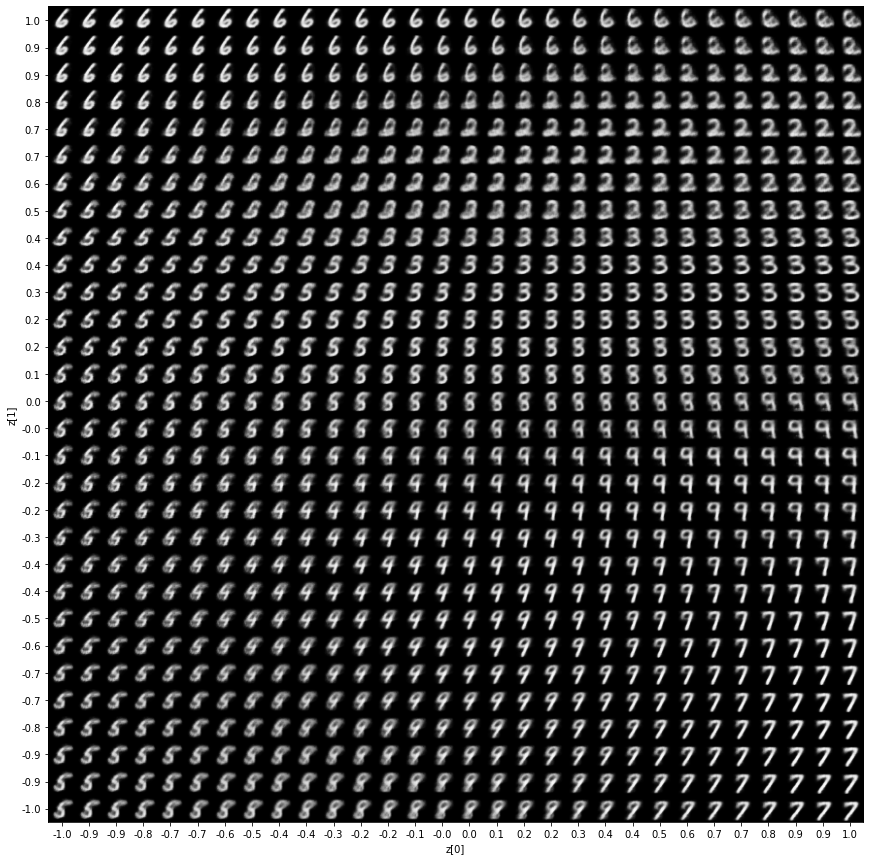

In [ ]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            print(xi, yi)
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

## Display how the latent space clusters different digit classes

sampling


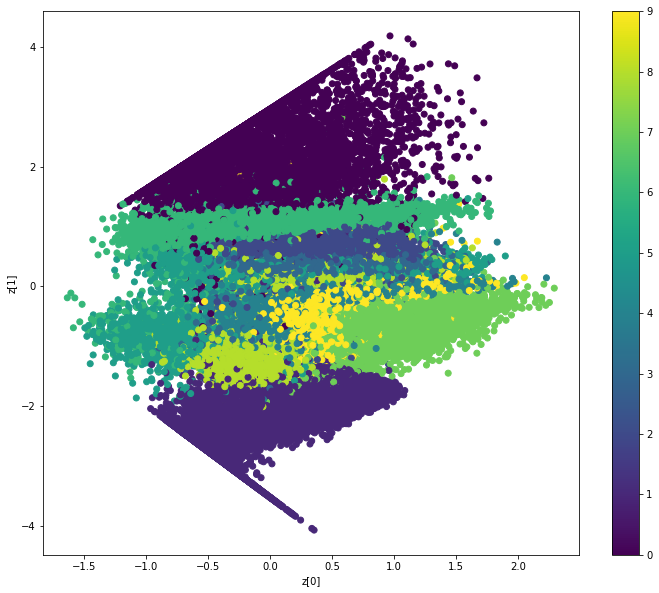

In [ ]:

def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)